### Machine Learning with Big Data
## Part 1: Fully Connected Layers

# 0.3 - experiments mlp

**Group:** MLBD_Deventer 4
**Students:** Mathijs Pattipeilohy (512391), Emin Fikret (511275)

## Setup and speed
enable xla mixed precision and gpu memory growth

In [16]:
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/opt/cuda'
import json, numpy as np, matplotlib.pyplot as plt, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import mixed_precision
from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

tf.config.optimizer.set_jit(True)
try: tf.config.experimental.enable_tensor_float_32_execution(True)
except: pass
mixed_precision.set_global_policy('mixed_float16')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try: tf.config.experimental.set_memory_growth(gpus[0], True)
    except: pass


## Load meta and data
use balanced train data and raw validation data

In [17]:
with open('../artifacts/metadata.json') as f:
    meta = json.load(f)
num_classes = len(meta['label_classes'])

x_train_path = '../artifacts/X_train_balanced.npy' if os.path.exists('../artifacts/X_train_balanced.npy') else '../artifacts/X_train.npy'
y_train_path = '../artifacts/y_train_balanced.npy' if os.path.exists('../artifacts/y_train_balanced.npy') else '../artifacts/y_train.npy'

X_train = np.load(x_train_path)
y_train = np.load(y_train_path)
X_val   = np.load('../artifacts/X_val.npy')
y_val   = np.load('../artifacts/y_val.npy')

y_train_oh = keras.utils.to_categorical(y_train, num_classes)
y_val_oh   = keras.utils.to_categorical(y_val,   num_classes)


## Make tf datasets
cast to float16 and build input pipeline

In [18]:
X_train = X_train.astype('float16', copy=False)
X_val   = X_val.astype('float16', copy=False)

BATCH = 1024
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train_oh)).cache().shuffle(10000).batch(BATCH).prefetch(tf.data.AUTOTUNE)
val_ds   = tf.data.Dataset.from_tensor_slices((X_val,   y_val_oh)).cache().batch(BATCH).prefetch(tf.data.AUTOTUNE)

os.makedirs('../artifacts/experiments', exist_ok=True)


# Define experiment configs
relu tanh sigmoid with and without dropout with different sizes

In [19]:
configs = [
    # relu no dropout
    {'name':'relu_1x64_do0',      'layers':[64],                  'act':'relu',    'dropout':0.0},
    {'name':'relu_2x128_do0',     'layers':[128,128],             'act':'relu',    'dropout':0.0},
    {'name':'relu_3x256_do0',     'layers':[256,256,256],         'act':'relu',    'dropout':0.0},

    # relu with dropout
    {'name':'relu_1x128_do02',    'layers':[128],                 'act':'relu',    'dropout':0.2},
    {'name':'relu_2x256_do02',    'layers':[256,256],             'act':'relu',    'dropout':0.2},
    {'name':'relu_3x256_do03',    'layers':[256,256,256],         'act':'relu',    'dropout':0.3},

    # tanh no dropout
    {'name':'tanh_1x128_do0',     'layers':[128],                 'act':'tanh',    'dropout':0.0},
    {'name':'tanh_2x128_do0',     'layers':[128,128],             'act':'tanh',    'dropout':0.0},

    # tanh with dropout
    {'name':'tanh_1x256_do02',    'layers':[256],                 'act':'tanh',    'dropout':0.2},
    {'name':'tanh_2x256_do02',    'layers':[256,256],             'act':'tanh',    'dropout':0.2},

    # sigmoid no dropout
    {'name':'sigmoid_1x128_do0',  'layers':[128],                 'act':'sigmoid', 'dropout':0.0},
    {'name':'sigmoid_2x128_do0',  'layers':[128,128],             'act':'sigmoid', 'dropout':0.0},

    # sigmoid with dropout
    {'name':'sigmoid_1x256_do02', 'layers':[256],                 'act':'sigmoid', 'dropout':0.2},
    {'name':'sigmoid_2x256_do03', 'layers':[256,256],             'act':'sigmoid', 'dropout':0.3},
]


## Model builder
this function builds a  simple neural network based on the settings you give it

1. **input layer**
   takes in one hand of cards as a list of numbers (the one hot encoded suits and ranks)

2. **hidden layers**
   for each number in the `layers` list
   it adds a dense (fully connected) layer with that many neurons
   it uses the activation function you picked (relu tanh or sigmoid)
   if dropout is higher than 0
   it adds a dropout layer to randomly turn off some neurons while training
   this helps to stop overfitting

3. **output layer**
   adds the final dense layer with one neuron per class
   uses softmax so the outputs add up to 1 and can be read as probabilities

4. **compile**
   uses the adam optimizer
   uses categorical crossentropy loss since this is a classification task
   measures how often it is correct with accuracy

5. **return**
   gives back the ready to train model








In [20]:
def build_model(input_dim, cfg, num_classes):
    inp = keras.Input(shape=(input_dim,))
    x = inp
    for u in cfg['layers']:
        x = keras.layers.Dense(u, activation=cfg['act'])(x)
        if cfg['dropout'] > 0.0:
            x = keras.layers.Dropout(cfg['dropout'])(x)
    out = keras.layers.Dense(num_classes, activation='softmax', dtype='float32')(x)
    m = keras.Model(inp, out)
    opt = keras.optimizers.legacy.Adam()
    m.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return m


# Run experiments
train each config save plots reports collect histories and confusion matrices

[1/14] relu_1x64_do0
Epoch 1/100
20/20 [==============================] - 1s 18ms/step - loss: 2.2357 - accuracy: 0.1989 - val_loss: 2.1601 - val_accuracy: 0.2306
Epoch 2/100
20/20 [==============================] - 0s 22ms/step - loss: 2.0349 - accuracy: 0.3171 - val_loss: 2.0789 - val_accuracy: 0.2896
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 1.8511 - accuracy: 0.4125 - val_loss: 1.9803 - val_accuracy: 0.3200
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 1.6706 - accuracy: 0.4785 - val_loss: 1.8995 - val_accuracy: 0.3195
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 1.5046 - accuracy: 0.5314 - val_loss: 1.8364 - val_accuracy: 0.3010
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 1.3627 - accuracy: 0.5763 - val_loss: 1.7476 - val_accuracy: 0.3230
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 1.2447 - accuracy: 0.6093 - val_loss: 1.6921 - val_acc

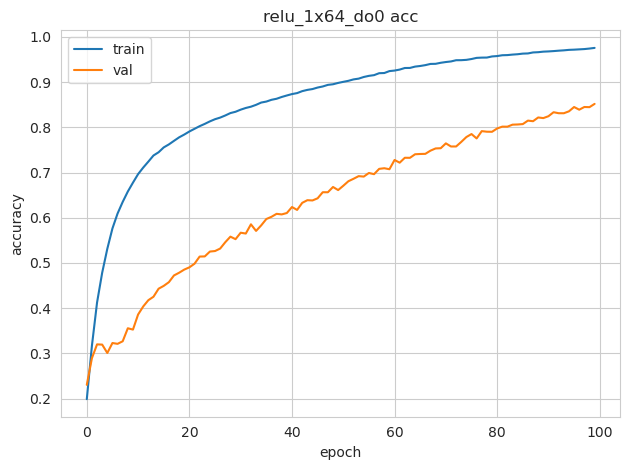

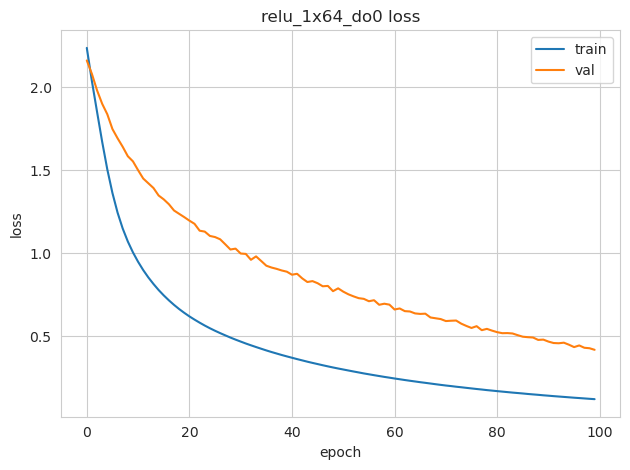

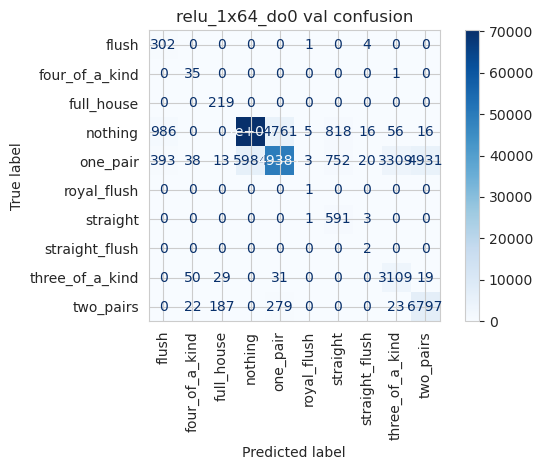

[2/14] relu_2x128_do0
Epoch 1/100
20/20 [==============================] - 1s 18ms/step - loss: 2.1196 - accuracy: 0.3034 - val_loss: 2.1642 - val_accuracy: 0.1650
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 1.6658 - accuracy: 0.4946 - val_loss: 1.9107 - val_accuracy: 0.2258
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 1.2219 - accuracy: 0.6029 - val_loss: 1.5915 - val_accuracy: 0.3640
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 0.9355 - accuracy: 0.6924 - val_loss: 1.4127 - val_accuracy: 0.4296
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.7574 - accuracy: 0.7490 - val_loss: 1.2606 - val_accuracy: 0.4752
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6362 - accuracy: 0.7808 - val_loss: 1.1186 - val_accuracy: 0.5225
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.5497 - accuracy: 0.8062 - val_loss: 1.0587 - val_accura

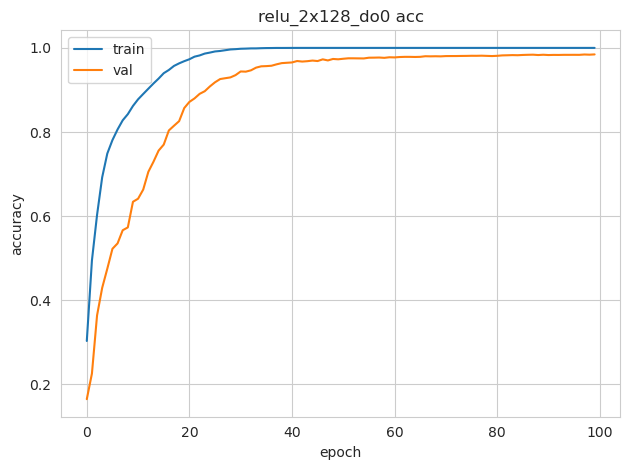

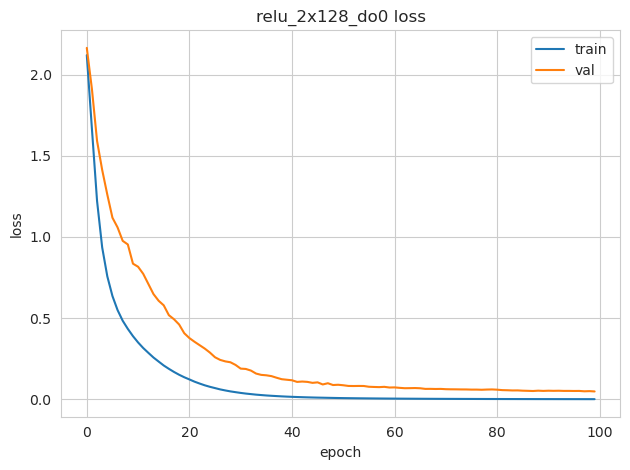

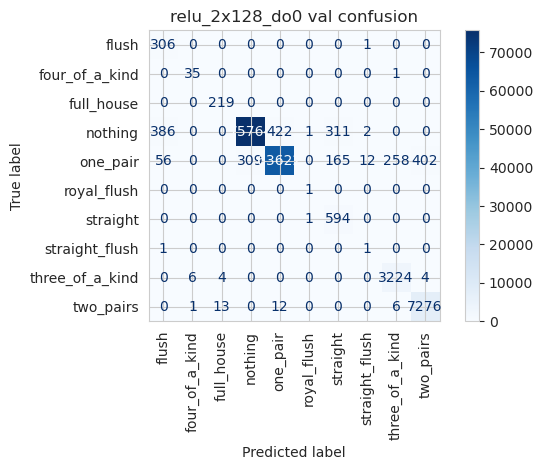

[3/14] relu_3x256_do0
Epoch 1/100
20/20 [==============================] - 1s 19ms/step - loss: 1.8922 - accuracy: 0.4349 - val_loss: 1.8397 - val_accuracy: 0.3054
Epoch 2/100
20/20 [==============================] - 0s 26ms/step - loss: 0.9852 - accuracy: 0.6622 - val_loss: 1.2797 - val_accuracy: 0.4550
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 0.5989 - accuracy: 0.7804 - val_loss: 1.0562 - val_accuracy: 0.5197
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 0.4300 - accuracy: 0.8378 - val_loss: 0.8390 - val_accuracy: 0.6323
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 0.3242 - accuracy: 0.8799 - val_loss: 0.6746 - val_accuracy: 0.7147
Epoch 6/100
20/20 [==============================] - 0s 9ms/step - loss: 0.2487 - accuracy: 0.9115 - val_loss: 0.5799 - val_accuracy: 0.7296
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.1859 - accuracy: 0.9412 - val_loss: 0.4426 - val_accura

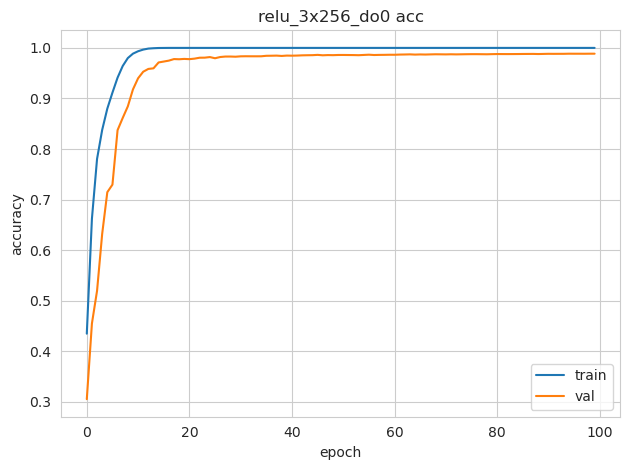

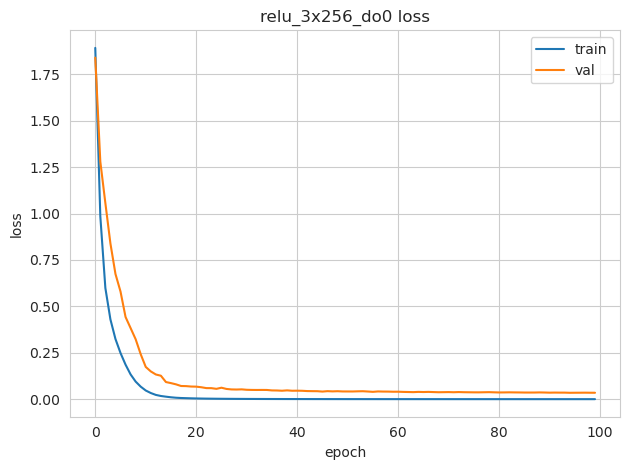

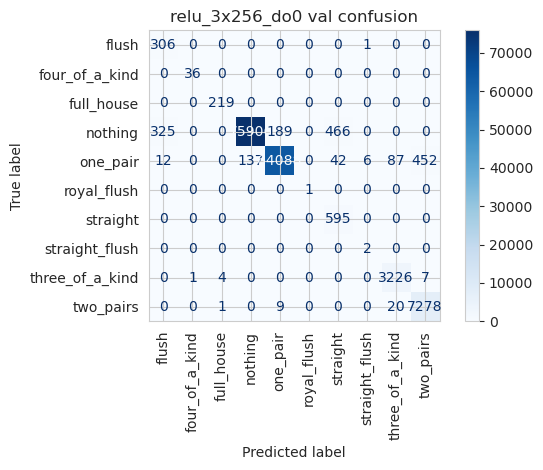

[4/14] relu_1x128_do02
Epoch 1/100
20/20 [==============================] - 1s 17ms/step - loss: 2.2073 - accuracy: 0.2212 - val_loss: 2.2186 - val_accuracy: 0.1666
Epoch 2/100
20/20 [==============================] - 0s 22ms/step - loss: 1.9137 - accuracy: 0.4173 - val_loss: 2.1114 - val_accuracy: 0.2062
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 1.6677 - accuracy: 0.4784 - val_loss: 1.9609 - val_accuracy: 0.2596
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 1.4683 - accuracy: 0.5288 - val_loss: 1.8333 - val_accuracy: 0.2958
Epoch 5/100
20/20 [==============================] - 0s 13ms/step - loss: 1.3146 - accuracy: 0.5685 - val_loss: 1.7356 - val_accuracy: 0.3238
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 1.1920 - accuracy: 0.6062 - val_loss: 1.6475 - val_accuracy: 0.3497
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 1.0978 - accuracy: 0.6366 - val_loss: 1.5637 - val_accu

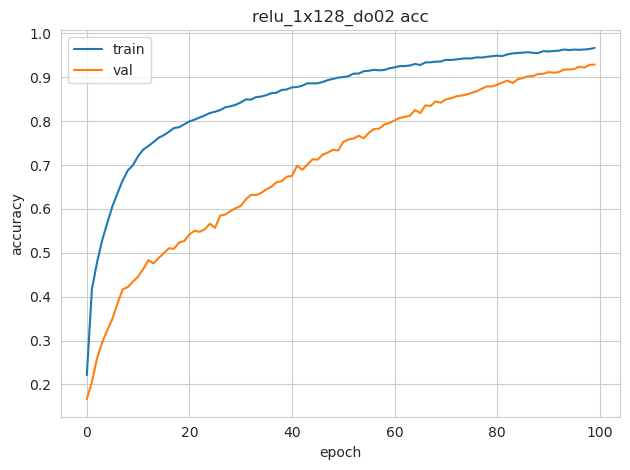

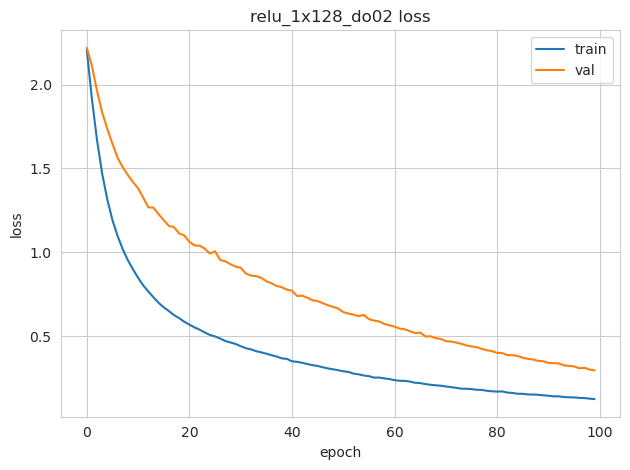

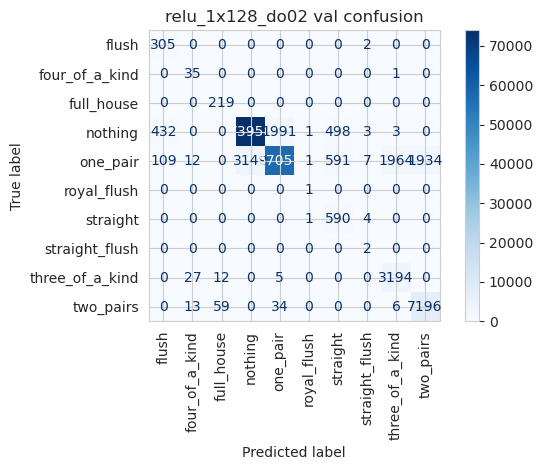

[5/14] relu_2x256_do02
Epoch 1/100
20/20 [==============================] - 1s 20ms/step - loss: 1.9942 - accuracy: 0.3671 - val_loss: 1.9939 - val_accuracy: 0.2562
Epoch 2/100
20/20 [==============================] - 1s 31ms/step - loss: 1.3443 - accuracy: 0.5570 - val_loss: 1.5472 - val_accuracy: 0.3975
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 0.9606 - accuracy: 0.6632 - val_loss: 1.3397 - val_accuracy: 0.4407
Epoch 4/100
20/20 [==============================] - 0s 10ms/step - loss: 0.7512 - accuracy: 0.7288 - val_loss: 1.1311 - val_accuracy: 0.5102
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.6272 - accuracy: 0.7699 - val_loss: 1.0434 - val_accuracy: 0.5535
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.5468 - accuracy: 0.7978 - val_loss: 0.9809 - val_accuracy: 0.5648
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 0.4819 - accuracy: 0.8212 - val_loss: 0.8833 - val_acc

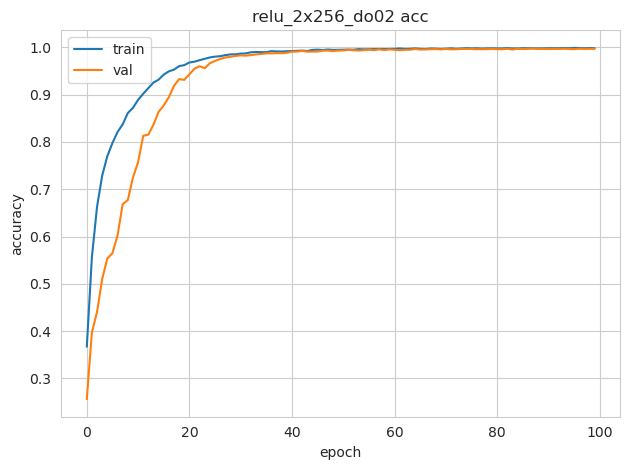

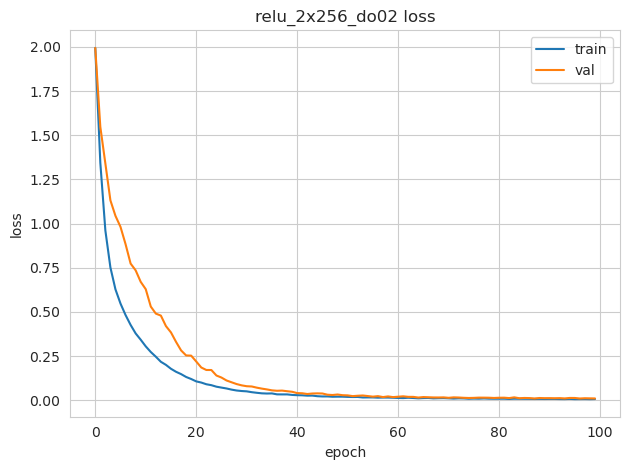

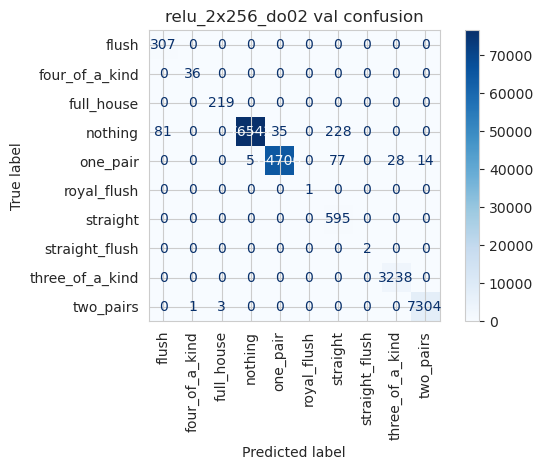

[6/14] relu_3x256_do03
Epoch 1/100
20/20 [==============================] - 2s 41ms/step - loss: 2.0073 - accuracy: 0.3120 - val_loss: 1.9920 - val_accuracy: 0.1392
Epoch 2/100
20/20 [==============================] - 1s 43ms/step - loss: 1.3128 - accuracy: 0.5088 - val_loss: 1.5854 - val_accuracy: 0.3329
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 0.9346 - accuracy: 0.6499 - val_loss: 1.2528 - val_accuracy: 0.4854
Epoch 4/100
20/20 [==============================] - 0s 12ms/step - loss: 0.7265 - accuracy: 0.7212 - val_loss: 1.0539 - val_accuracy: 0.5422
Epoch 5/100
20/20 [==============================] - 0s 12ms/step - loss: 0.6117 - accuracy: 0.7618 - val_loss: 0.9725 - val_accuracy: 0.5674
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 0.5297 - accuracy: 0.7908 - val_loss: 0.8352 - val_accuracy: 0.6192
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.4660 - accuracy: 0.8188 - val_loss: 0.7980 - val_

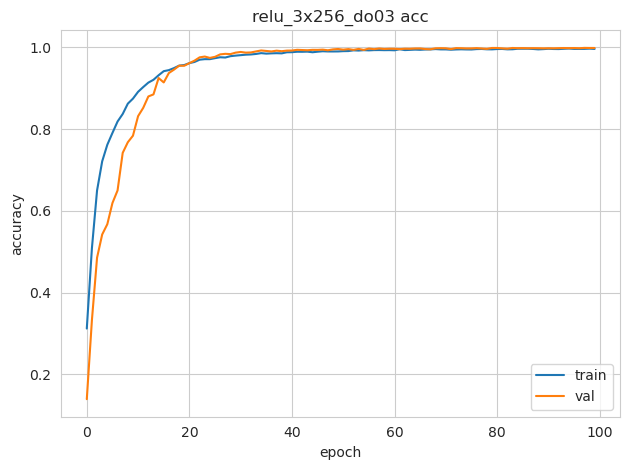

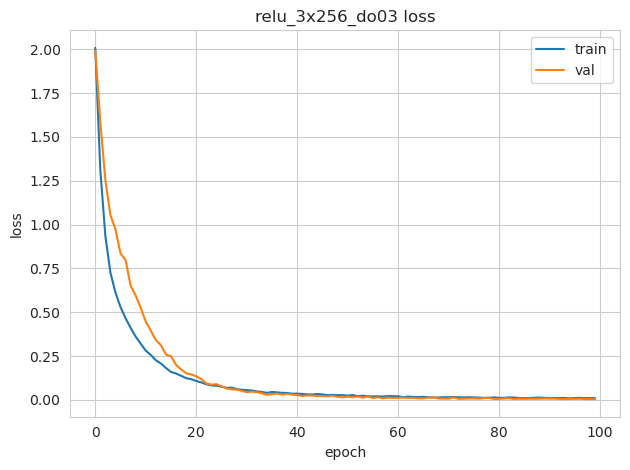

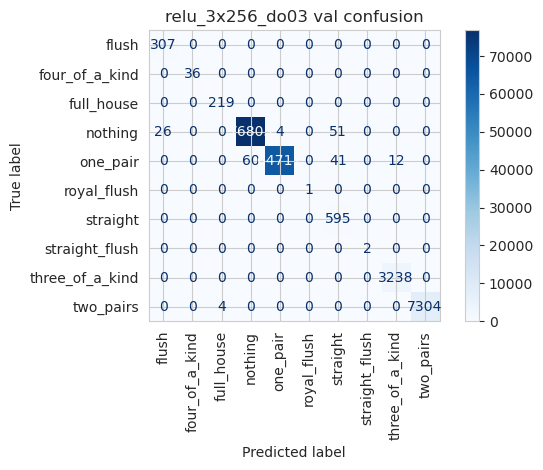

[7/14] tanh_1x128_do0
Epoch 1/100
20/20 [==============================] - 1s 17ms/step - loss: 2.1659 - accuracy: 0.2321 - val_loss: 2.1921 - val_accuracy: 0.1482
Epoch 2/100
20/20 [==============================] - 0s 21ms/step - loss: 1.8058 - accuracy: 0.4223 - val_loss: 2.0472 - val_accuracy: 0.1612
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 1.5777 - accuracy: 0.4805 - val_loss: 1.8965 - val_accuracy: 0.2236
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 1.4210 - accuracy: 0.5210 - val_loss: 1.7975 - val_accuracy: 0.2451
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 1.3106 - accuracy: 0.5453 - val_loss: 1.7401 - val_accuracy: 0.2506
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 1.2322 - accuracy: 0.5638 - val_loss: 1.6957 - val_accuracy: 0.2364
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 1.1747 - accuracy: 0.5770 - val_loss: 1.6608 - val_accura

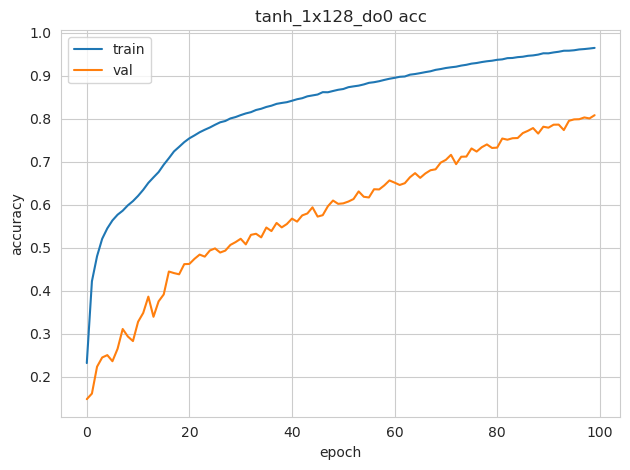

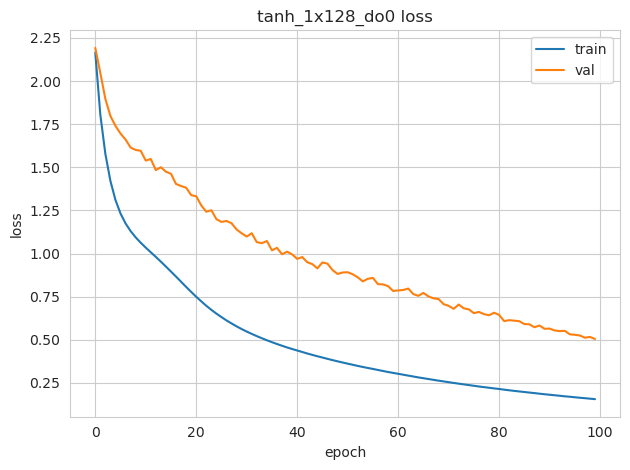

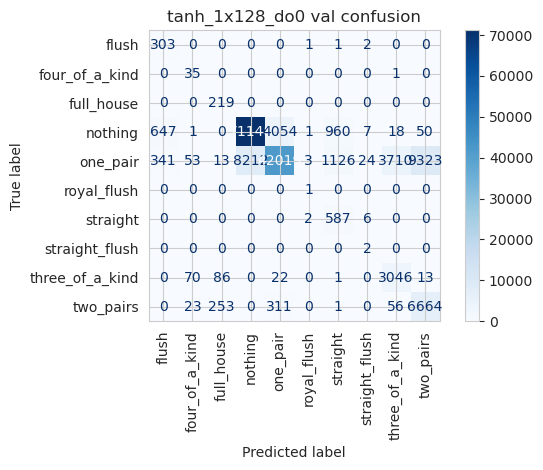

[8/14] tanh_2x128_do0
Epoch 1/100
20/20 [==============================] - 1s 18ms/step - loss: 1.9592 - accuracy: 0.3395 - val_loss: 2.0385 - val_accuracy: 0.1499
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 1.4777 - accuracy: 0.4996 - val_loss: 1.8119 - val_accuracy: 0.1899
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 1.2553 - accuracy: 0.5443 - val_loss: 1.6484 - val_accuracy: 0.2833
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 1.1359 - accuracy: 0.5817 - val_loss: 1.5858 - val_accuracy: 0.3526
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 1.0566 - accuracy: 0.6170 - val_loss: 1.5559 - val_accuracy: 0.3272
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.9910 - accuracy: 0.6445 - val_loss: 1.5200 - val_accuracy: 0.3606
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 0.9234 - accuracy: 0.6789 - val_loss: 1.4733 - val_accura

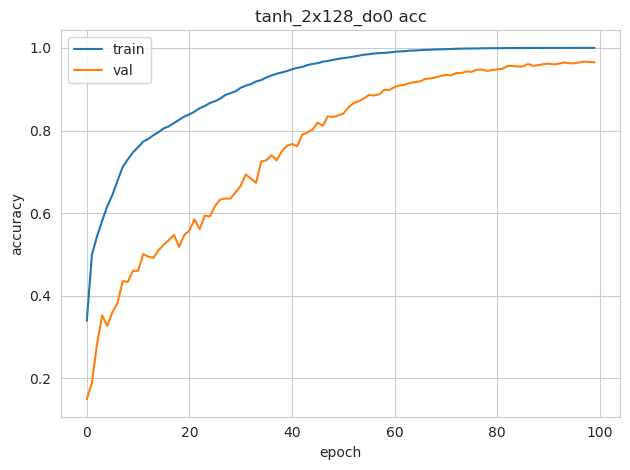

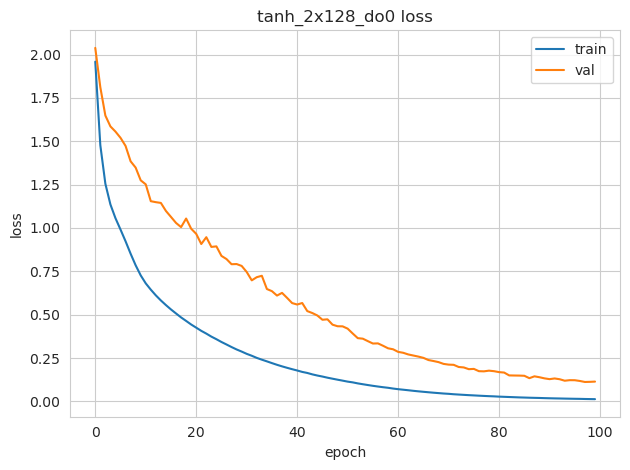

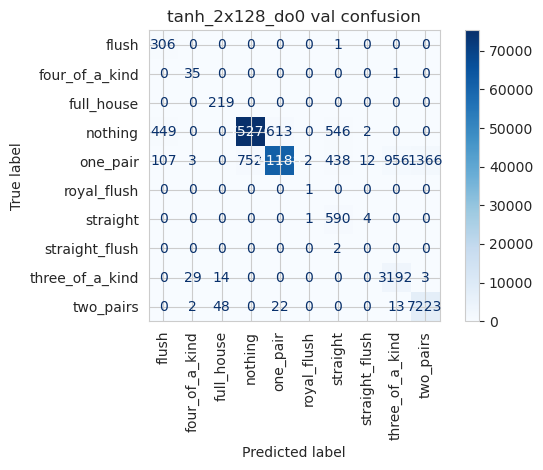

[9/14] tanh_1x256_do02
Epoch 1/100
20/20 [==============================] - 1s 21ms/step - loss: 2.0519 - accuracy: 0.3002 - val_loss: 2.0540 - val_accuracy: 0.2365
Epoch 2/100
20/20 [==============================] - 1s 27ms/step - loss: 1.6278 - accuracy: 0.4669 - val_loss: 1.9026 - val_accuracy: 0.2193
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 1.4073 - accuracy: 0.5244 - val_loss: 1.7602 - val_accuracy: 0.2889
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 1.2802 - accuracy: 0.5454 - val_loss: 1.7096 - val_accuracy: 0.2306
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 1.2050 - accuracy: 0.5562 - val_loss: 1.6878 - val_accuracy: 0.2254
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 1.1547 - accuracy: 0.5663 - val_loss: 1.6286 - val_accuracy: 0.2686
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 1.1165 - accuracy: 0.5779 - val_loss: 1.6166 - val_

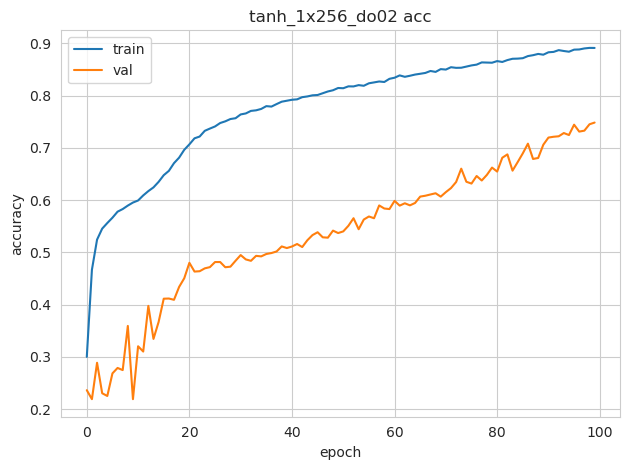

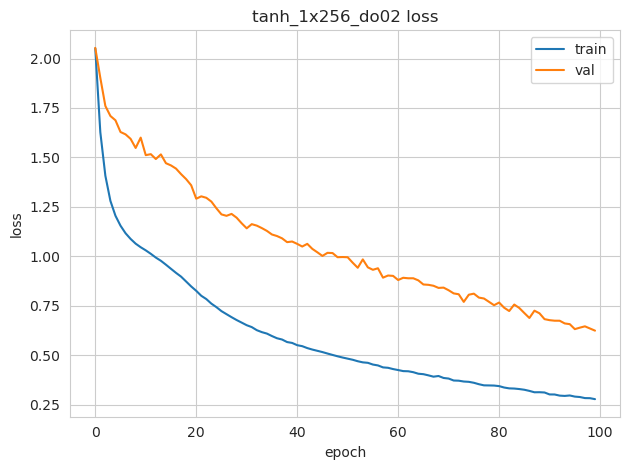

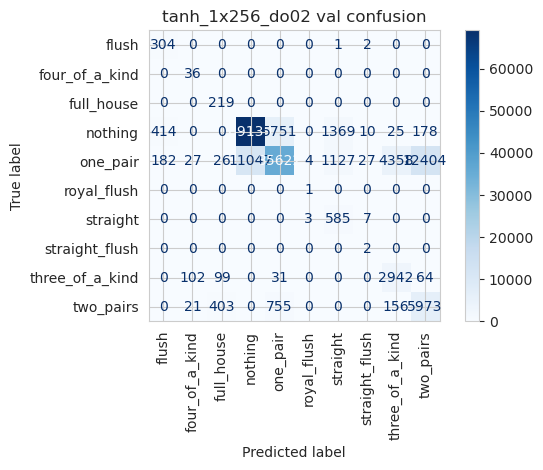

[10/14] tanh_2x256_do02
Epoch 1/100
20/20 [==============================] - 1s 19ms/step - loss: 1.8031 - accuracy: 0.3789 - val_loss: 1.8546 - val_accuracy: 0.1783
Epoch 2/100
20/20 [==============================] - 1s 31ms/step - loss: 1.3157 - accuracy: 0.5231 - val_loss: 1.6780 - val_accuracy: 0.1668
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 1.1570 - accuracy: 0.5587 - val_loss: 1.6089 - val_accuracy: 0.3015
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 1.0932 - accuracy: 0.5773 - val_loss: 1.5164 - val_accuracy: 0.3768
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0395 - accuracy: 0.5971 - val_loss: 1.5493 - val_accuracy: 0.3147
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 0.9928 - accuracy: 0.6241 - val_loss: 1.4593 - val_accuracy: 0.3378
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 0.9330 - accuracy: 0.6566 - val_loss: 1.3721 - val_a

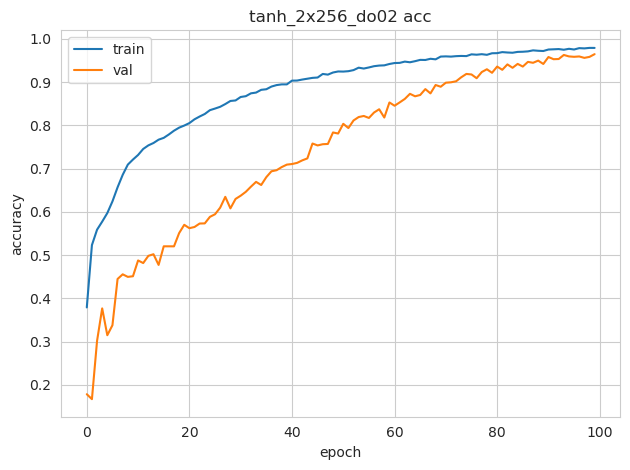

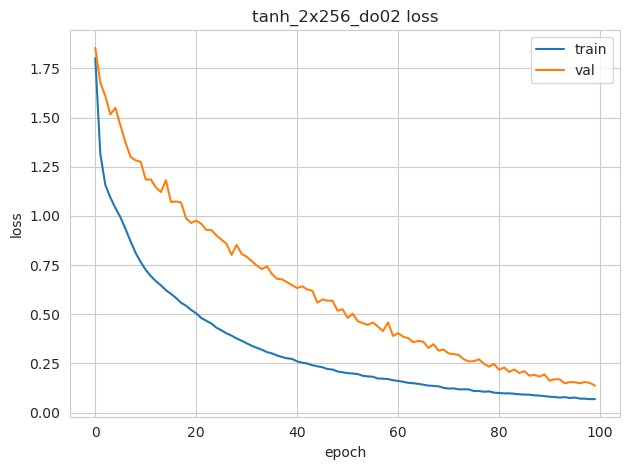

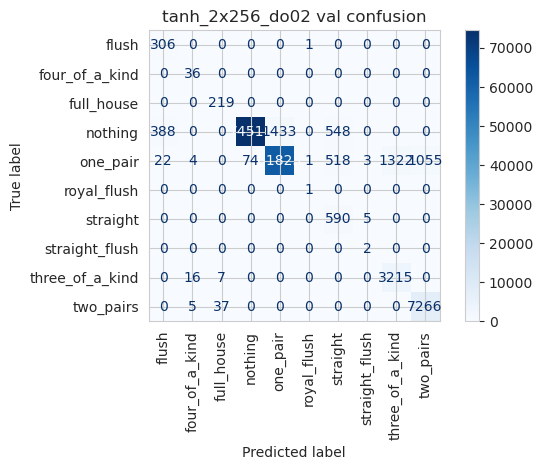

[11/14] sigmoid_1x128_do0
Epoch 1/100
20/20 [==============================] - 1s 19ms/step - loss: 2.3187 - accuracy: 0.1808 - val_loss: 2.2674 - val_accuracy: 0.1061
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 2.1644 - accuracy: 0.3474 - val_loss: 2.2424 - val_accuracy: 0.1444
Epoch 3/100
20/20 [==============================] - 0s 11ms/step - loss: 2.0557 - accuracy: 0.4081 - val_loss: 2.2045 - val_accuracy: 0.1854
Epoch 4/100
20/20 [==============================] - 0s 11ms/step - loss: 1.9558 - accuracy: 0.4257 - val_loss: 2.1438 - val_accuracy: 0.2331
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 1.8608 - accuracy: 0.4521 - val_loss: 2.1224 - val_accuracy: 0.0982
Epoch 6/100
20/20 [==============================] - 0s 12ms/step - loss: 1.7739 - accuracy: 0.4661 - val_loss: 2.0475 - val_accuracy: 0.1917
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 1.6939 - accuracy: 0.4758 - val_loss: 1.9984 - val

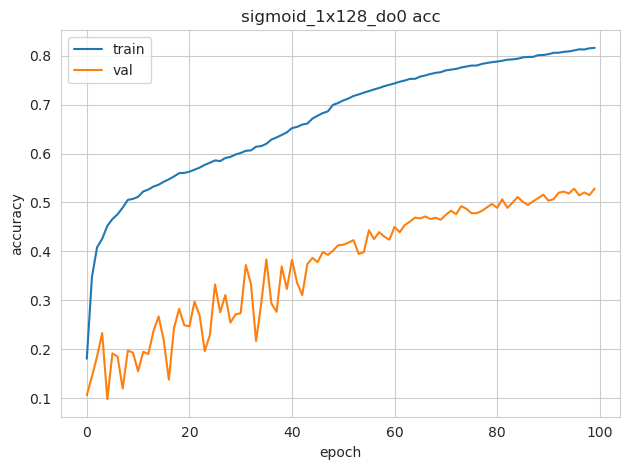

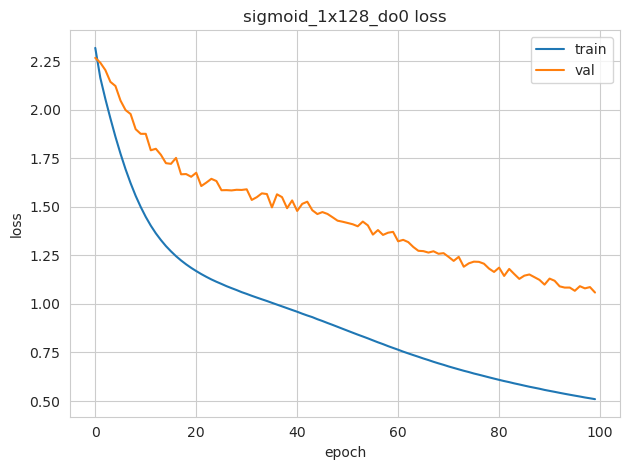

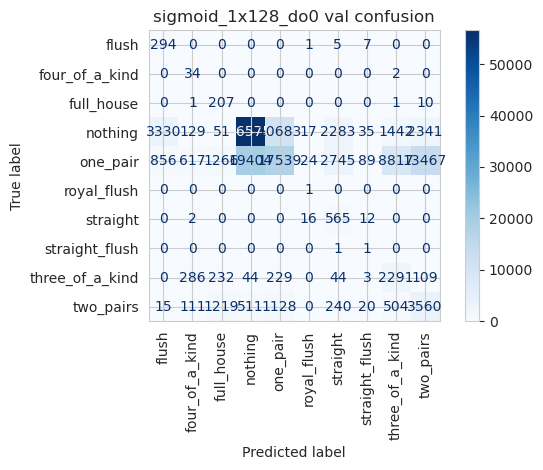

[12/14] sigmoid_2x128_do0
Epoch 1/100
20/20 [==============================] - 1s 21ms/step - loss: 2.3285 - accuracy: 0.1145 - val_loss: 2.3395 - val_accuracy: 0.0039
Epoch 2/100
20/20 [==============================] - 1s 34ms/step - loss: 2.2568 - accuracy: 0.2220 - val_loss: 2.3358 - val_accuracy: 0.0144
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 2.1951 - accuracy: 0.3343 - val_loss: 2.2907 - val_accuracy: 0.0222
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 2.0965 - accuracy: 0.3740 - val_loss: 2.2979 - val_accuracy: 0.0241
Epoch 5/100
20/20 [==============================] - 0s 11ms/step - loss: 1.9743 - accuracy: 0.4011 - val_loss: 2.1130 - val_accuracy: 0.3008
Epoch 6/100
20/20 [==============================] - 0s 11ms/step - loss: 1.8493 - accuracy: 0.4225 - val_loss: 2.0417 - val_accuracy: 0.3088
Epoch 7/100
20/20 [==============================] - 0s 11ms/step - loss: 1.7232 - accuracy: 0.4415 - val_loss: 1.9430 - va

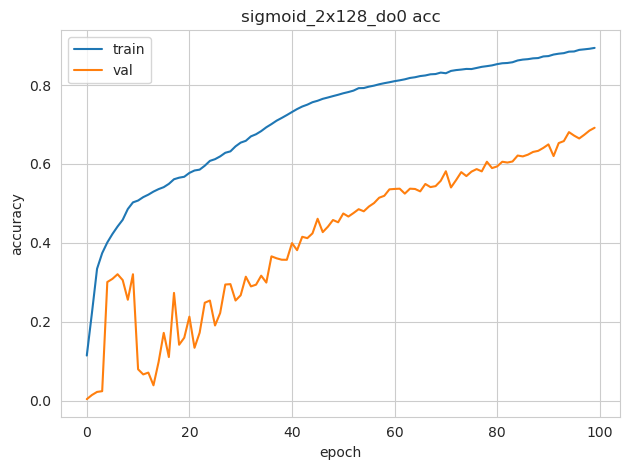

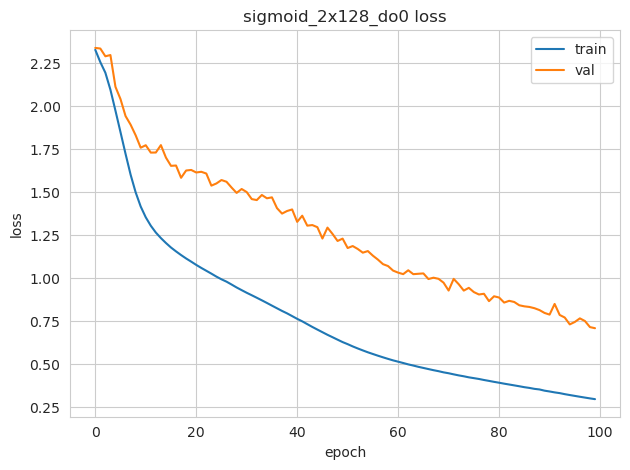

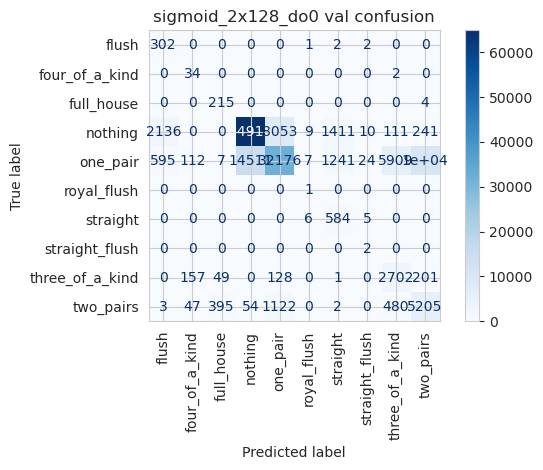

[13/14] sigmoid_1x256_do02
Epoch 1/100
20/20 [==============================] - 1s 18ms/step - loss: 2.3004 - accuracy: 0.1477 - val_loss: 2.1261 - val_accuracy: 0.4266
Epoch 2/100
20/20 [==============================] - 0s 23ms/step - loss: 2.1428 - accuracy: 0.2526 - val_loss: 2.1437 - val_accuracy: 0.2650
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 2.0092 - accuracy: 0.3217 - val_loss: 2.1677 - val_accuracy: 0.0452
Epoch 4/100
20/20 [==============================] - 0s 8ms/step - loss: 1.8951 - accuracy: 0.3672 - val_loss: 2.0595 - val_accuracy: 0.2605
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 1.7919 - accuracy: 0.4013 - val_loss: 2.0150 - val_accuracy: 0.1368
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 1.7018 - accuracy: 0.4281 - val_loss: 2.0021 - val_accuracy: 0.1093
Epoch 7/100
20/20 [==============================] - 0s 8ms/step - loss: 1.6245 - accuracy: 0.4412 - val_loss: 1.9441 - val_a

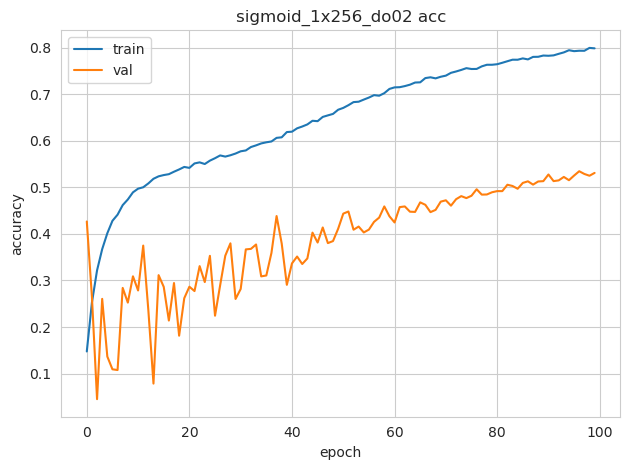

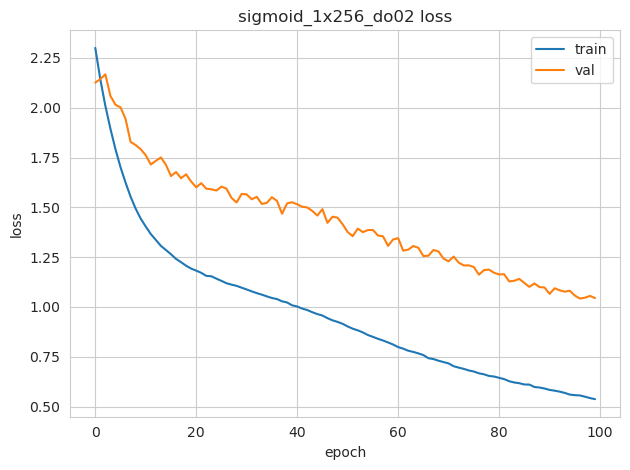

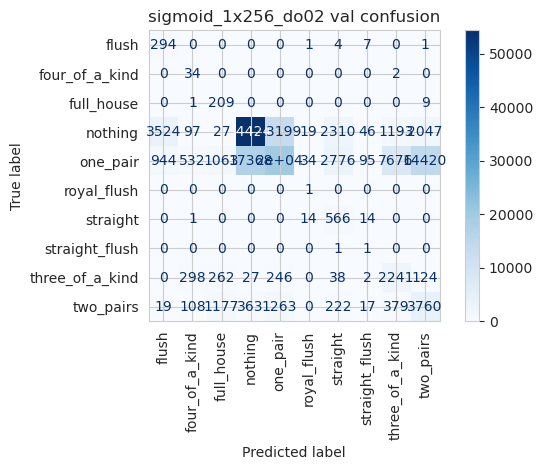

[14/14] sigmoid_2x256_do03
Epoch 1/100
20/20 [==============================] - 1s 19ms/step - loss: 2.3852 - accuracy: 0.1092 - val_loss: 2.2627 - val_accuracy: 0.2069
Epoch 2/100
20/20 [==============================] - 1s 27ms/step - loss: 2.2898 - accuracy: 0.1450 - val_loss: 2.2841 - val_accuracy: 0.1188
Epoch 3/100
20/20 [==============================] - 0s 9ms/step - loss: 2.1911 - accuracy: 0.2150 - val_loss: 2.2733 - val_accuracy: 0.0239
Epoch 4/100
20/20 [==============================] - 0s 9ms/step - loss: 2.0661 - accuracy: 0.2645 - val_loss: 2.2007 - val_accuracy: 0.0029
Epoch 5/100
20/20 [==============================] - 0s 9ms/step - loss: 1.9355 - accuracy: 0.3109 - val_loss: 2.0113 - val_accuracy: 0.3872
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 1.8042 - accuracy: 0.3550 - val_loss: 1.9819 - val_accuracy: 0.3302
Epoch 7/100
20/20 [==============================] - 0s 9ms/step - loss: 1.6827 - accuracy: 0.3950 - val_loss: 1.9400 - val_a

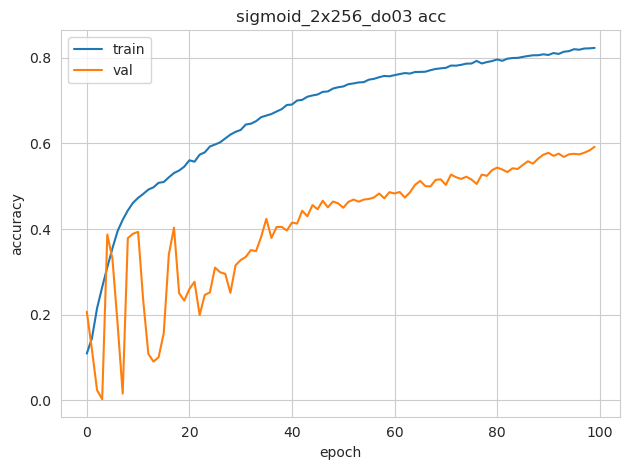

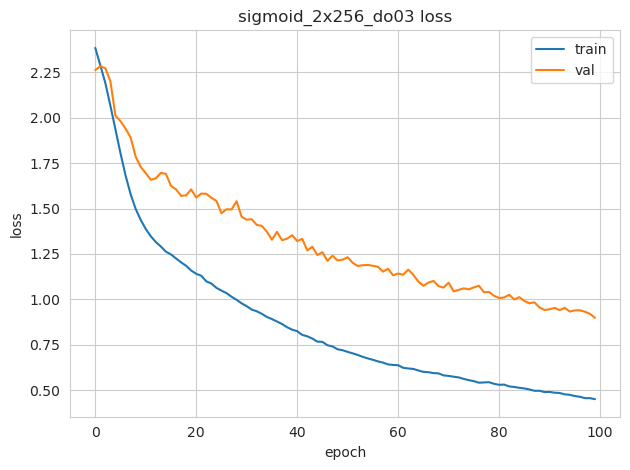

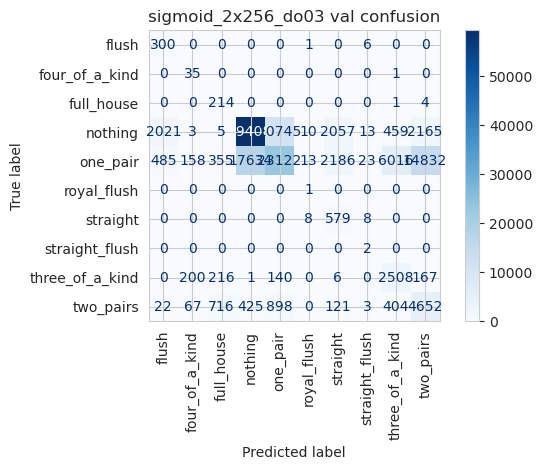

best by macro f1 relu_3x256_do03 0.987461876958829


In [21]:
best_name = None
best_metric = -1.0
results = []
histories = {}          # store curves for combined plots
confusions = {}         # store cm arrays for later display

EPOCHS = 100

for i, cfg in enumerate(configs, 1):
    print(f'[{i}/{len(configs)}] {cfg["name"]}')
    model = build_model(X_train.shape[1], cfg, num_classes)
    hist = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        verbose=1
    )

    histories[cfg['name']] = {
        'act': cfg['act'],
        'val_accuracy': hist.history.get('val_accuracy', []),
        'val_loss': hist.history.get('val_loss', []),
        'train_accuracy': hist.history.get('accuracy', []),
        'train_loss': hist.history.get('loss', [])
    }

    # per run plots show and save
    acc_path  = f"../artifacts/experiments/{cfg['name']}_acc.png"
    loss_path = f"../artifacts/experiments/{cfg['name']}_loss.png"
    plt.figure(); plt.plot(hist.history['accuracy']); plt.plot(hist.history['val_accuracy']); plt.legend(['train','val']); plt.title(cfg['name']+' acc'); plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.tight_layout(); plt.savefig(acc_path, dpi=150); plt.show()
    plt.figure(); plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']); plt.legend(['train','val']); plt.title(cfg['name']+' loss'); plt.xlabel('epoch'); plt.ylabel('loss'); plt.tight_layout(); plt.savefig(loss_path, dpi=150); plt.show()

    # val metrics
    yv_pred = model.predict(X_val, batch_size=4096, verbose=0).argmax(1)
    macro_f1 = f1_score(y_val, yv_pred, average='macro')
    val_acc  = float(np.mean(yv_pred == y_val))

    # confusion matrix save and keep for end
    cm = confusion_matrix(y_val, yv_pred)
    confusions[cfg['name']] = cm
    disp = ConfusionMatrixDisplay(cm, display_labels=meta['label_classes'])
    disp.plot(xticks_rotation=90, cmap='Blues')
    plt.title(cfg['name']+' val confusion')
    plt.tight_layout()
    plt.savefig(f"../artifacts/experiments/{cfg['name']}_val_confusion.png", dpi=150)
    plt.show()

    # classification report
    rep = classification_report(y_val, yv_pred, target_names=meta['label_classes'])
    with open(f"../artifacts/experiments/{cfg['name']}_val_report.txt",'w') as f: f.write(rep)

    results.append({'name':cfg['name'],'layers':cfg['layers'],'act':cfg['act'],'dropout':cfg['dropout'],'val_acc':val_acc,'macro_f1':float(macro_f1)})

    if macro_f1 > best_metric:
        best_metric = macro_f1
        best_name = cfg['name']
        model.save('../artifacts/best_so_far.keras')
        with open('../artifacts/best_so_far_name.txt','w') as f: f.write(best_name)

# save summary json
with open('../artifacts/experiments/results.json','w') as f:
    json.dump(results, f, indent=2)

print('best by macro f1', best_name, best_metric)


## Combined plots per activation
show and save combined validation curves per activation group

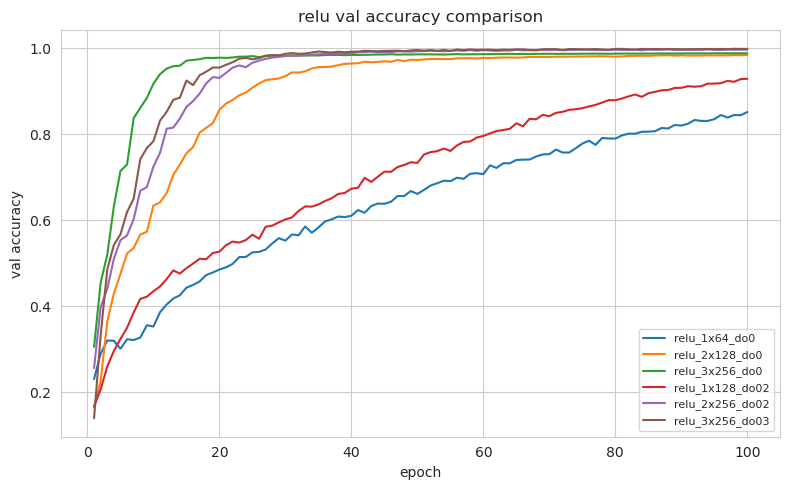

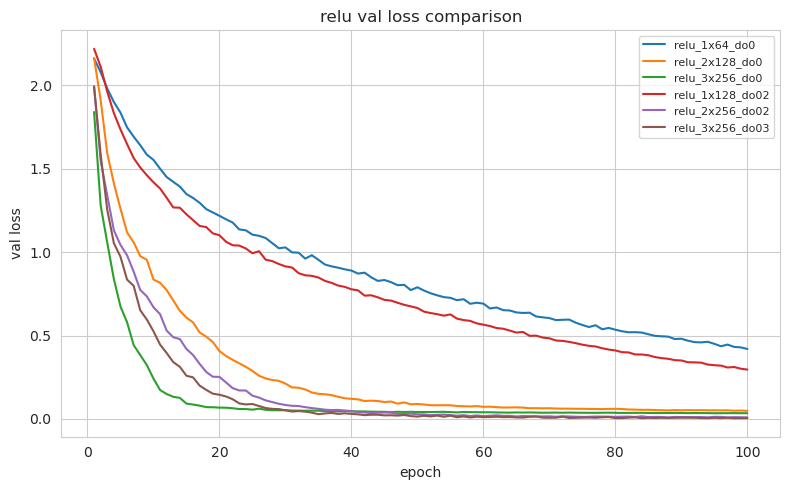

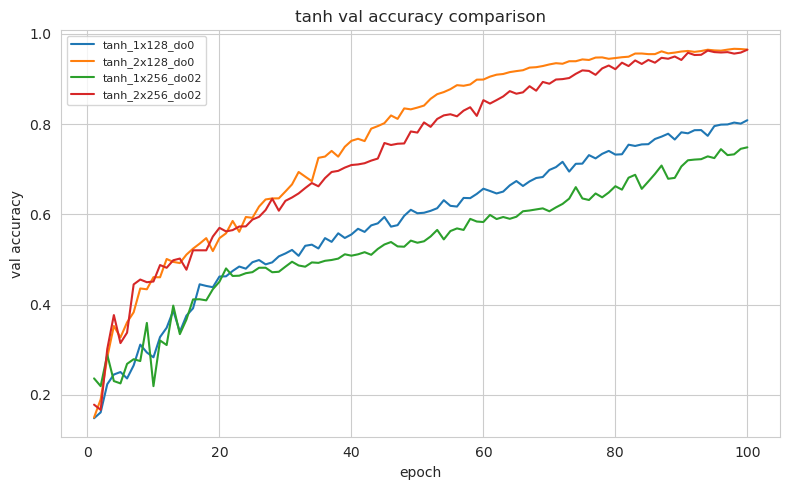

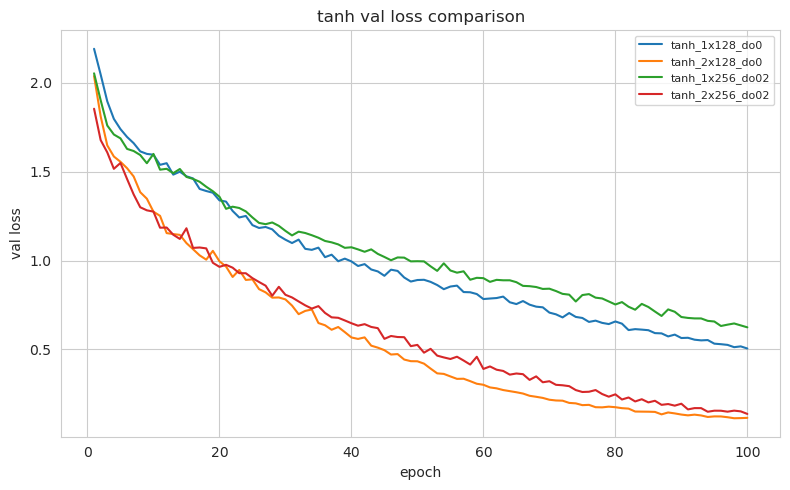

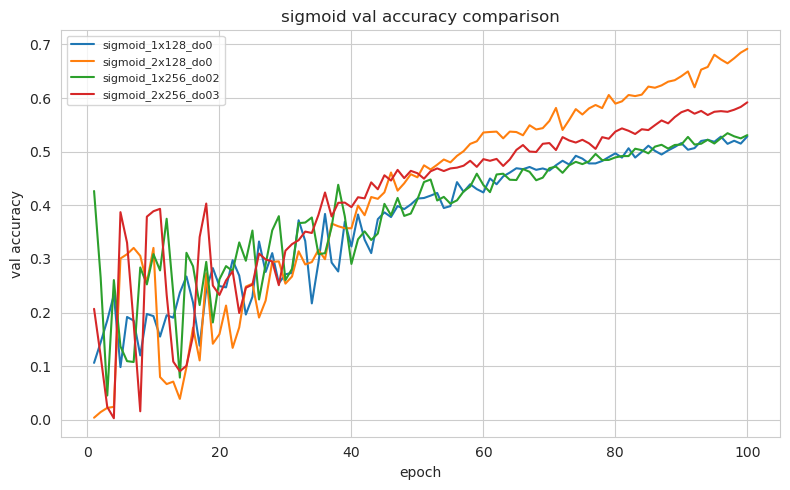

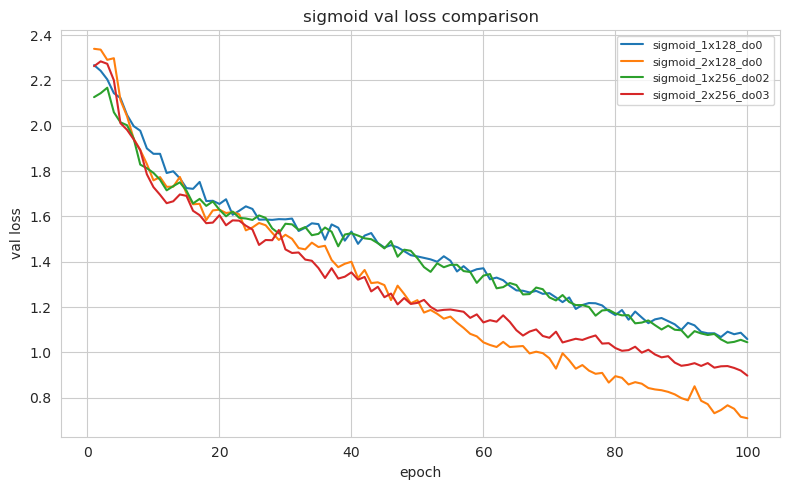

In [22]:
# group names by activation
by_act = {}
for name, h in histories.items():
    act = h['act']
    by_act.setdefault(act, []).append(name)

# make combined plots for each activation
for act, names in by_act.items():
    # val accuracy
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_accuracy']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title(f'{act} val accuracy comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_accuracy_{act}.png', dpi=150)
    plt.show()

    # val loss
    plt.figure(figsize=(8,5))
    for name in names:
        vals = histories[name]['val_loss']
        plt.plot(range(1, len(vals)+1), vals, label=name)
    plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title(f'{act} val loss comparison'); plt.legend(fontsize=8)
    plt.tight_layout()
    plt.savefig(f'../artifacts/experiments/combined_val_loss_{act}.png', dpi=150)
    plt.show()


## Overall combined plots

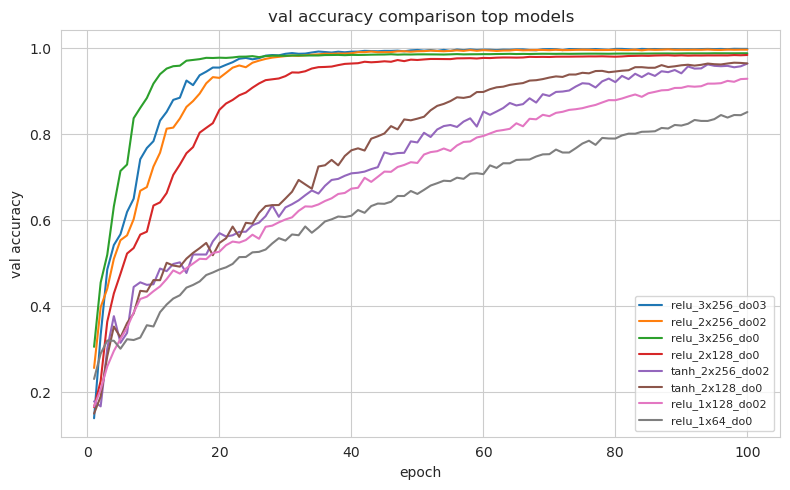

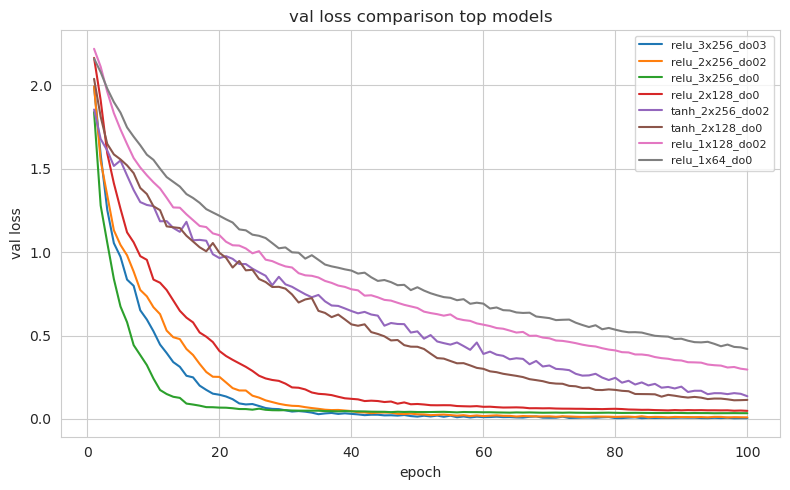

In [23]:
names_sorted = [r['name'] for r in sorted(results, key=lambda x: x['macro_f1'], reverse=True)]
top_names = names_sorted[:8]

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_accuracy']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val accuracy'); plt.title('val accuracy comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_accuracy_top.png', dpi=150)
plt.show()

plt.figure(figsize=(8,5))
for name in top_names:
    vals = histories[name]['val_loss']
    plt.plot(range(1, len(vals)+1), vals, label=name)
plt.xlabel('epoch'); plt.ylabel('val loss'); plt.title('val loss comparison top models'); plt.legend(fontsize=8)
plt.tight_layout()
plt.savefig('../artifacts/experiments/combined_val_loss_top.png', dpi=150)
plt.show()


## Conclusion

when comparing the different activation functions, relu clearly gives the best results. the sigmoid models show unstable and low validation accuracy, meaning they have trouble learning complex patterns in the poker hand data. the tanh models perform better than sigmoid but still remain below the relu models in both accuracy and consistency.

within the relu models, deeper networks with more neurons perform much better than smaller ones. models with one or two layers learn slower and reach lower accuracy, while three-layer models with larger hidden sizes show strong improvement.

when comparing dropout vs no dropout, the relu_3x256 model without dropout learns faster and reaches high accuracy in fewer epochs, but it plateaus earlier. the relu_3x256_do03 model learns a bit slower but keeps improving gradually and ends up with slightly higher accuracy and lower loss after 30 epochs. the difference is small, but it suggests that dropout helps the model generalize a little better and remain more stable during training.

when training relu models for 100 epochs, both versions start to plateau, but the validation accuracy curve of the dropout model stays slightly above the one without dropout. this confirms that even though the effect is small, dropout still helps the model perform a bit better in the long run.

so of the models we have the model relu with 3 x 256 with dropout 0.3 is the best.

## Visualize results json
these two bar charts show how each model performs based on macro f1 and validation accuracy, sorted by macro f1 score

macro f1 gives a better picture of how well the model performs across all classes, while validation accuracy can sometimes be biased if some poker hand types appear more often than others

what we can see:

the relu models are clearly the best again they take the top spots in both macro f1 and validation accuracy

relu_3x256_do03 has the highest macro f1 and validation accuracy meaning it performs best and most consistently across all hand types

the tanh models follow behind relu with moderate performance

sigmoid models are at the bottom in both metrics showing poor classification ability

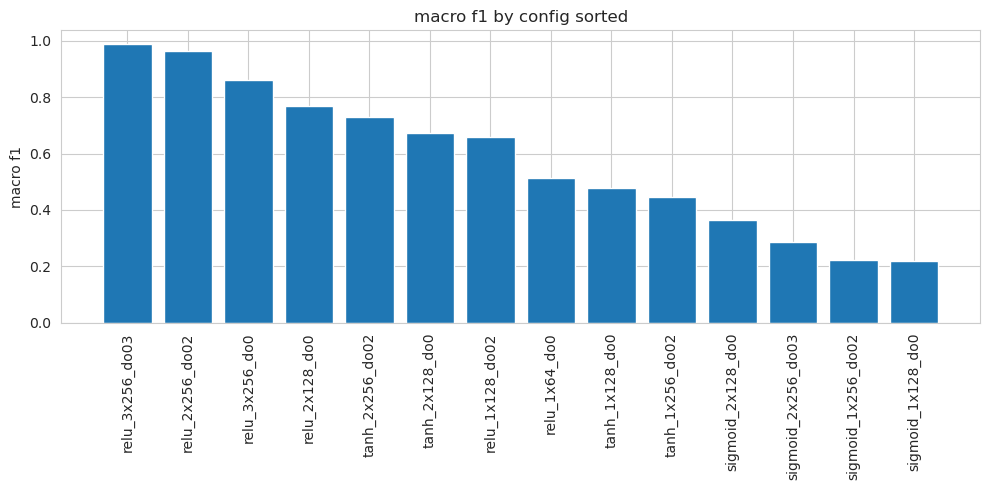

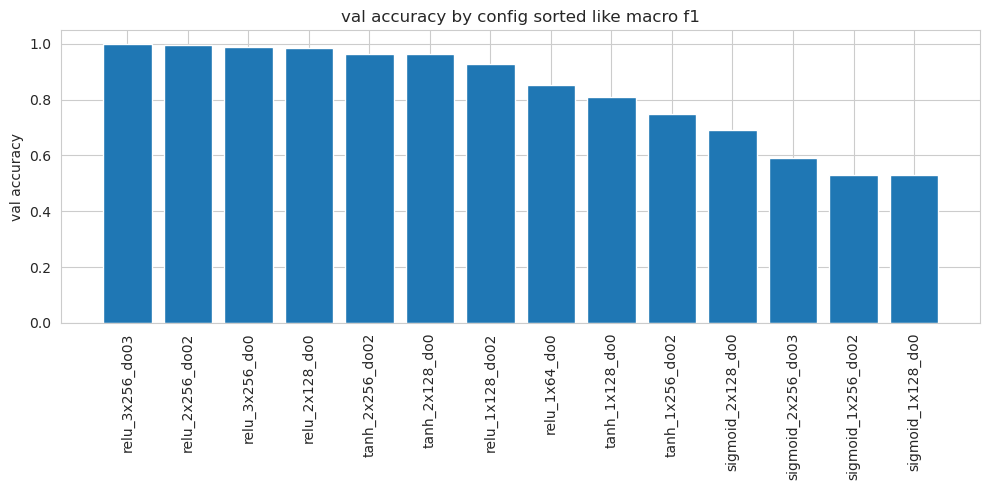

In [24]:
# ensure results is loaded if this cell runs alone
if 'results' not in globals():
    with open('../artifacts/experiments/results.json') as f:
        results = json.load(f)

# sort by macro f1
results_sorted = sorted(results, key=lambda x: x['macro_f1'], reverse=True)
names = [r['name'] for r in results_sorted]
val_accs = [r['val_acc'] for r in results_sorted]
macro_f1s = [r['macro_f1'] for r in results_sorted]

# macro f1 bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), macro_f1s)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('macro f1'); plt.title('macro f1 by config sorted')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_macro_f1.png', dpi=150)
plt.show()

# val acc bar
plt.figure(figsize=(10,5))
plt.bar(range(len(names)), val_accs)
plt.xticks(range(len(names)), names, rotation=90)
plt.ylabel('val accuracy'); plt.title('val accuracy by config sorted like macro f1')
plt.tight_layout()
plt.savefig('../artifacts/experiments/results_val_acc.png', dpi=150)
plt.show()
